In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

TRAINING_FOLDER = "C:\\Users\\Admin\\OneDrive - Politecnico di Milano\\phd\\code\\multivariate_hawkes\\data\\trained_params\\multivariate_hawkes\\BTC_USD\\lshade_logged_training_time_900"

In [2]:
trained_dfs = []
for gen_number in range(1, 201):
    df = pd.read_csv(
        Path(TRAINING_FOLDER)
        / "orderbook_changes_1705356920082_1705353321_logs"
        / f"population_gen{gen_number}.tsv",
        sep="\t",
        header=None,
        names=[f"mu_{i}" for i in range(3)]
        + [f"alpha_{i}" for i in range(9)]
        + [f"beta_{i}" for i in range(9)],
    )

    for i in range(9):
        df[f"rho_{i}"] = df[f"alpha_{i}"] / df[f"beta_{i}"]

    df = df.reset_index(names="individual")
    melted_df = pd.melt(
        df, id_vars=["individual"], var_name="param", value_name="value"
    )
    melted_df["param_index"] = melted_df["param"].apply(lambda x: x.split("_")[1])
    melted_df["param_index"] = melted_df["param_index"].astype(int)
    melted_df["param_type"] = melted_df["param"].apply(lambda x: x.split("_")[0])

    df_fitness = pd.read_csv(
        Path(TRAINING_FOLDER)
        / "orderbook_changes_1705356920082_1705353321_logs"
        / f"fitnesses_gen{gen_number}.tsv",
        sep="\t",
        header=None,
        names=["fitness"],
    ).reset_index(names="individual")

    gen_df = melted_df.merge(df_fitness, on="individual")
    gen_df["generation"] = gen_number
    trained_dfs.append(gen_df)

trained_df = pd.concat(trained_dfs, ignore_index=True)
trained_df.head()

individual param     value  param_index param_type      fitness  generation
0           0  mu_0  0.015419            0         mu  3568.433777           1
1           1  mu_0  0.106511            0         mu  4310.572293           1
2           2  mu_0  0.190053            0         mu  3515.228734           1
3           3  mu_0  0.049455            0         mu  3916.458460           1
4           4  mu_0  0.188889            0         mu  3845.033731           1

## Plot how max likelihood change in generations

<Axes: xlabel='generation'>

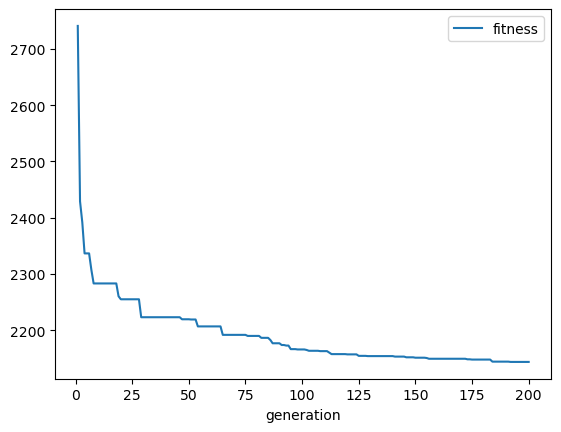

In [3]:
trained_df[["fitness", "generation"]].groupby("generation").min().plot()

TODO: Check why there are increase in fitness

## Check if individuals are similar

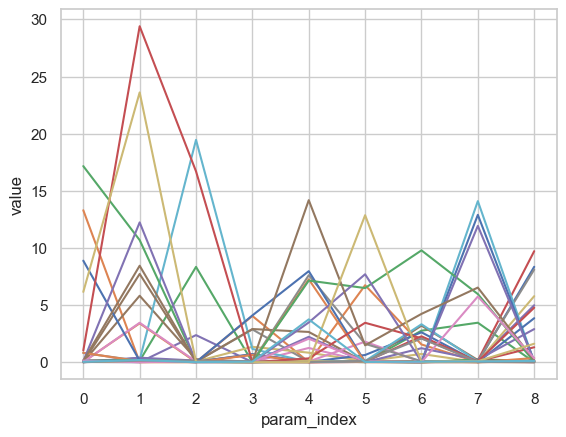

In [124]:
for i in range(30):
    sns.lineplot(
        data=trained_df[
            (trained_df["param_type"] == "alpha")
            & (trained_df["generation"] == 1)
            & (trained_df["individual"] == 100 * i)
        ],
        x="param_index",
        y="value",
    )

TODO: Check why initialization do not seem so random? It seems that each parameter has its own distribution

In [3]:
list(range(1, 200, 20))

[1, 21, 41, 61, 81, 101, 121, 141, 161, 181]

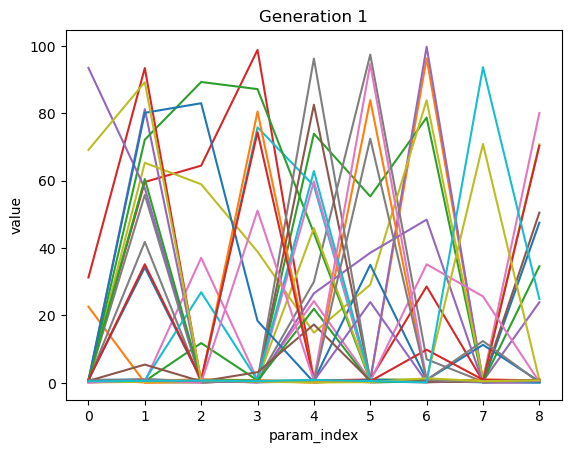

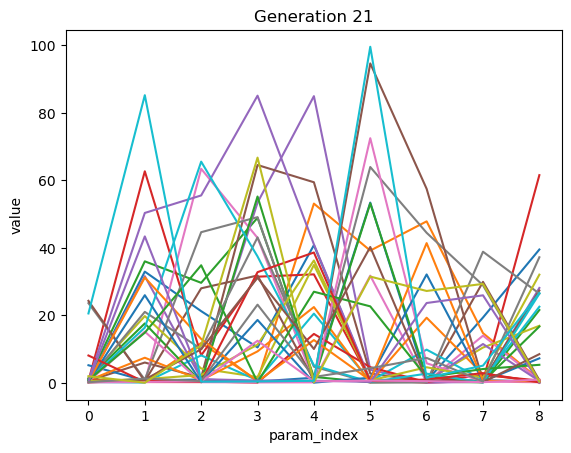

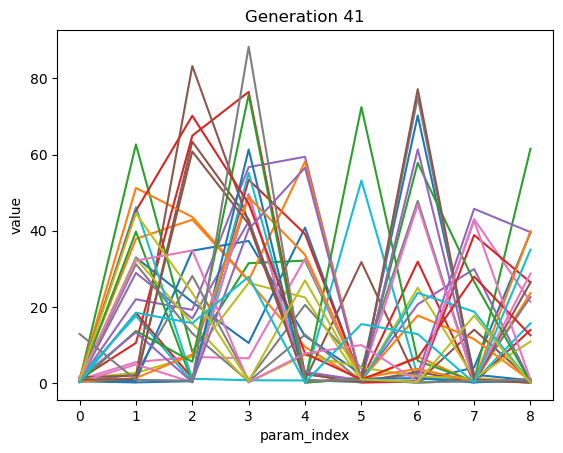

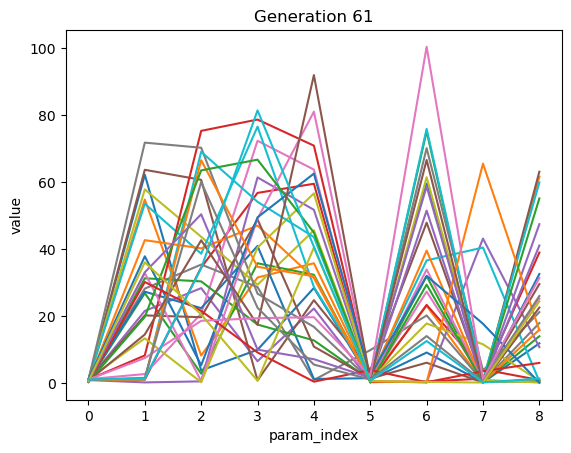

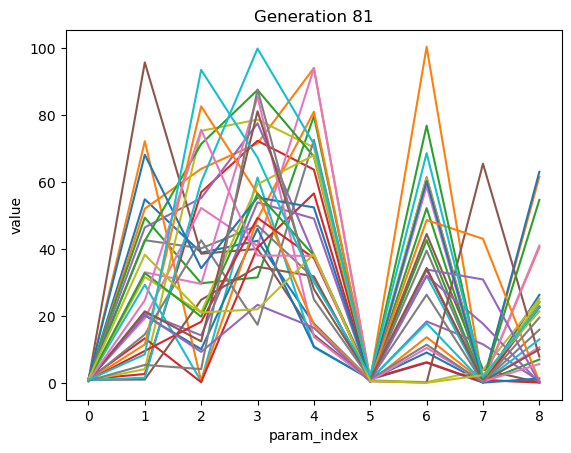

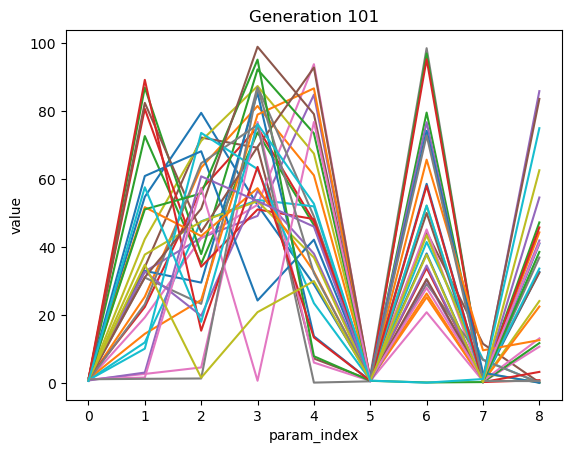

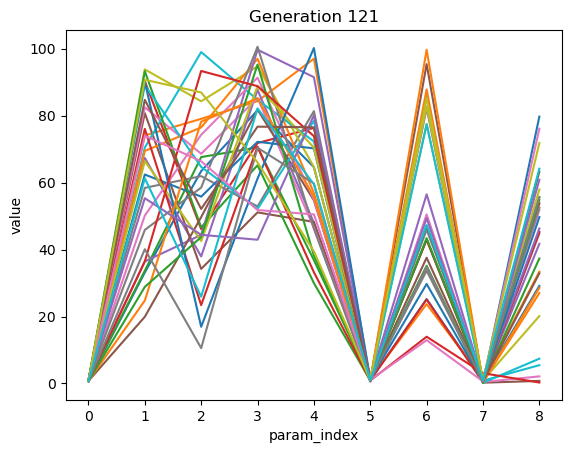

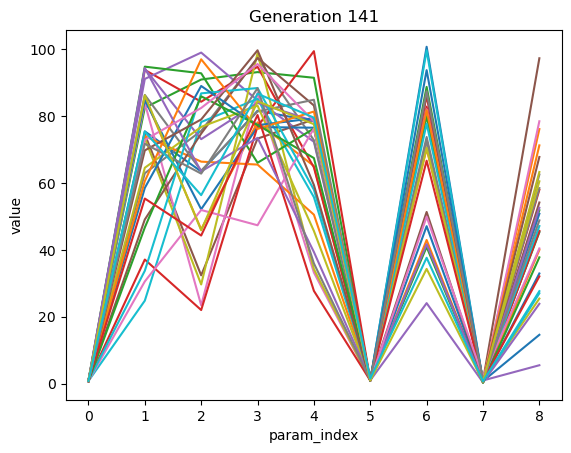

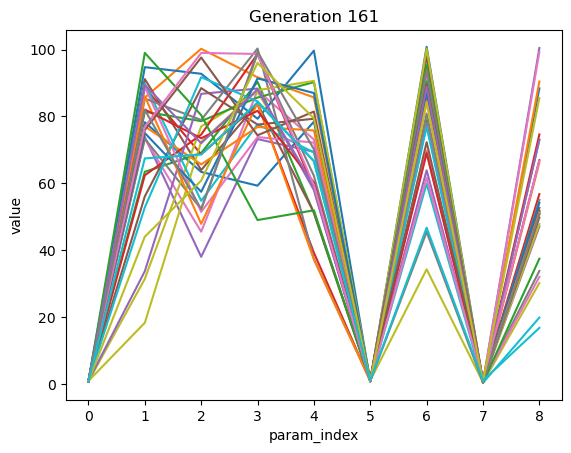

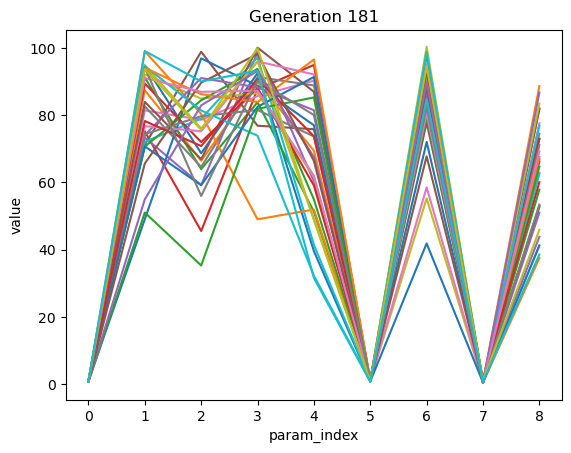

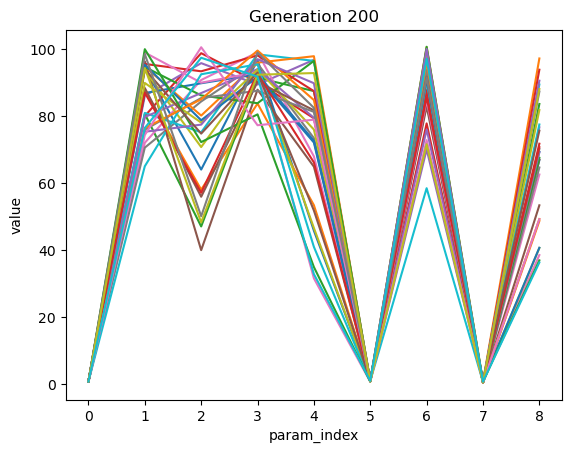

In [5]:
for gen in list(range(1, 200, 20)) + [200]:
    for i in range(30):

        sns.lineplot(
            data=trained_df[
                (trained_df["param_type"] == "beta")
                & (trained_df["generation"] == gen)
                & (trained_df["individual"] == i)
            ],
            x="param_index",
            y="value",
        )
    # plt.ylim(0, 1)
    plt.title(f"Generation {gen}")
    plt.show()

<Axes: xlabel='param_index', ylabel='value'>

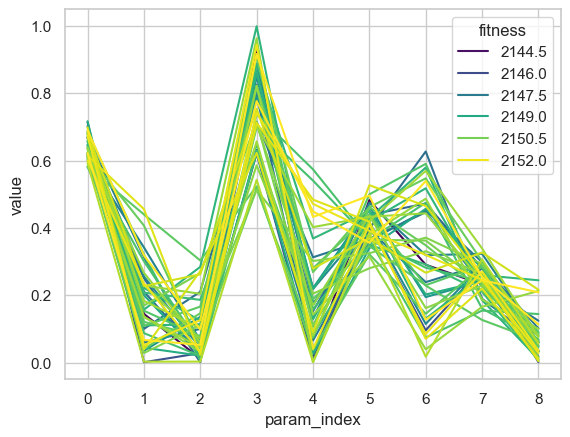

In [131]:
data_subset = trained_df[
    (trained_df["param_type"] == "alpha") & (trained_df["generation"] == 190)
]

# Create the lineplot with 'individual' as the hue
sns.lineplot(
    data=data_subset,
    x="param_index",
    y="value",
    hue="fitness",  # Use 'fitness' to color the lines
    palette="viridis",  # Choose a suitable color palette
)

<Axes: xlabel='param_index', ylabel='value'>

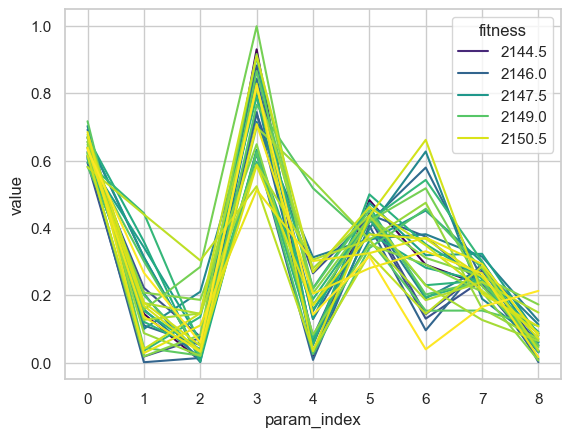

In [134]:
data_subset = trained_df[
    (trained_df["param_type"] == "alpha") & (trained_df["generation"] == 200)
]

# Create the lineplot with 'individual' as the hue
sns.lineplot(
    data=data_subset,
    x="param_index",
    y="value",
    hue="fitness",  # Use 'fitness' to color the lines
    palette="viridis",  # Choose a suitable color palette
)

TODO: why the worst is not discarded?

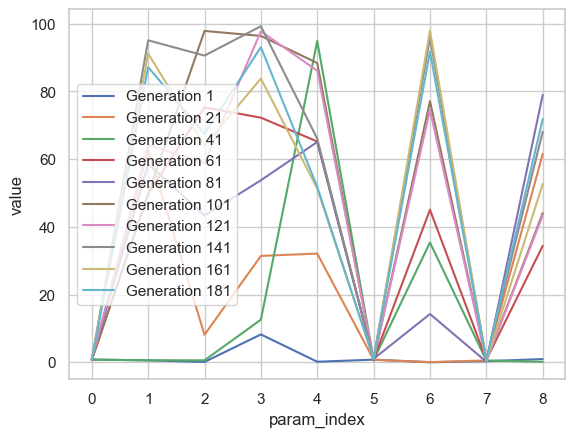

In [137]:
# get the individual with the best fitness for each generation (not the index) but the individual number
# Create a DataFrame with the individual with lowest fitness for each generation
best_individuals = trained_df.loc[trained_df.groupby("generation")["fitness"].idxmin()][
    ["generation", "individual"]
]
best_individuals = best_individuals.merge(trained_df, on=["generation", "individual"])

# Create the lineplot with 'individual' as the hue
for gen in range(1, 201, 20):
    sns.lineplot(
        data=best_individuals[
            (best_individuals["param_type"] == "beta")
            & (best_individuals["generation"] == gen)
        ],
        x="param_index",
        y="value",
        label=f"Generation {gen}",
    )

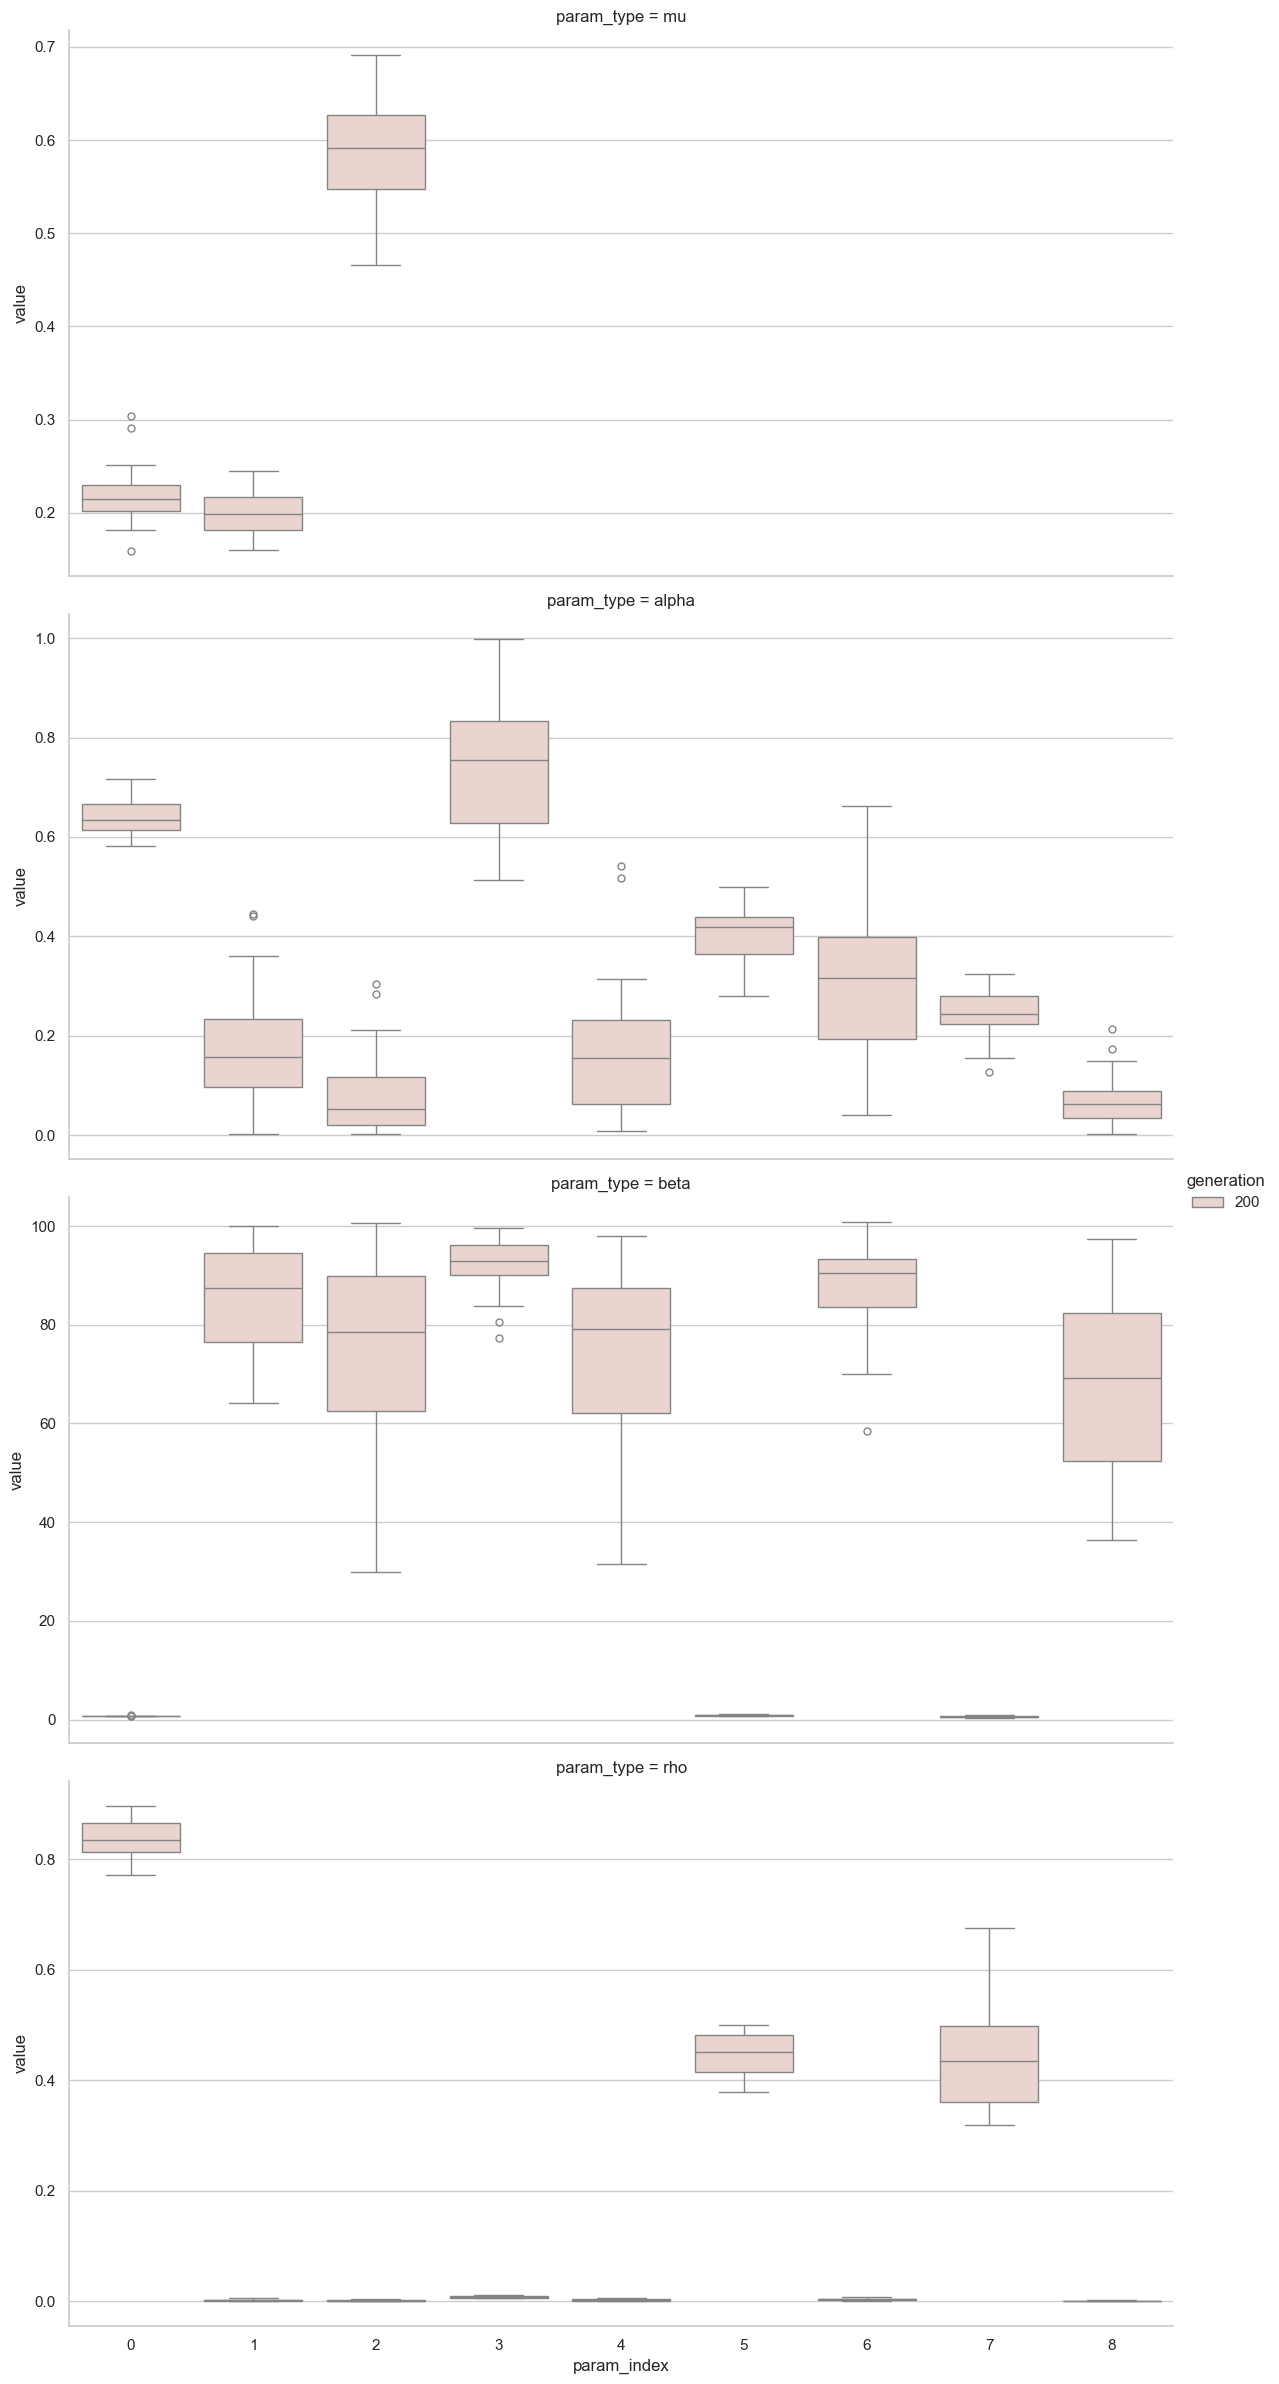

In [4]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=trained_df[(trained_df["generation"].isin([200]))],
    x="param_index",
    y="value",
    hue="generation",
    col=None,  # No columns
    row="param_type",  # Facet by the "param" variable (1 column, 3 rows)
    kind="box",  # Boxplot
    height=6,  # Height of each facet
    aspect=2,  # Aspect ratio of each facet
    sharey=False,  # Share the y-axis between facets
    # showfliers=False,  # Do not show outliers
)

In [85]:
df.head()

param_index         0         1
individual                     
0            0.525090  0.143745
1            0.322341  0.737918
2            0.681468  0.065172
3            0.924514  0.429766
4            0.556695  0.224232

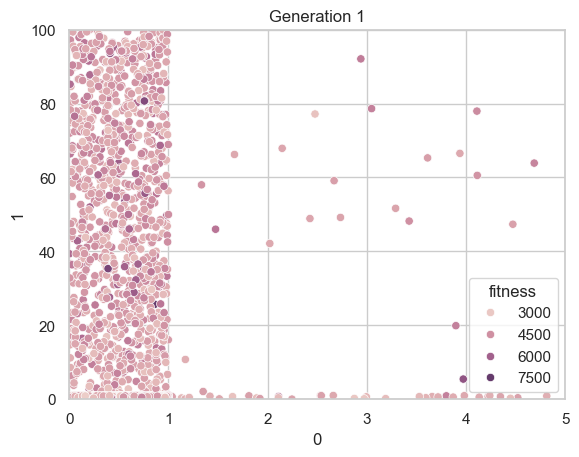

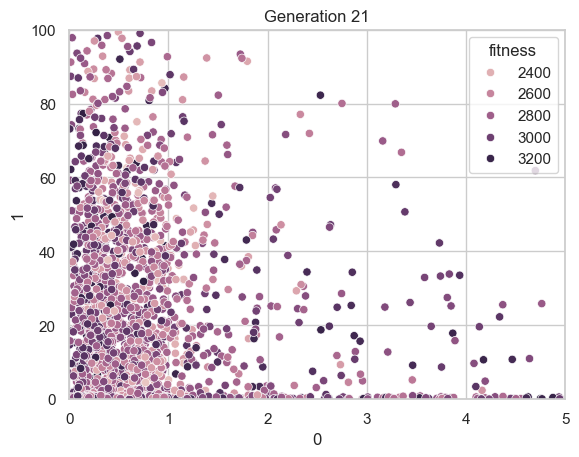

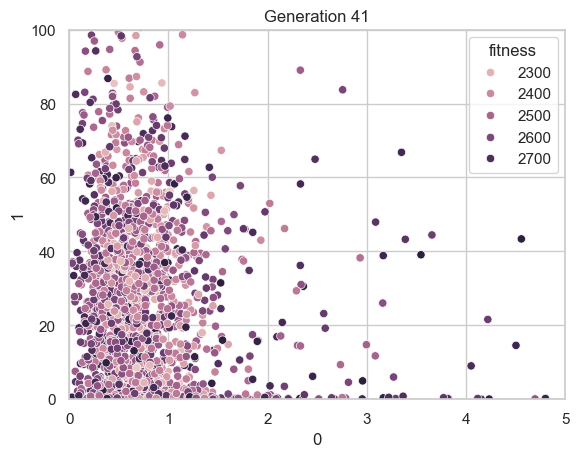

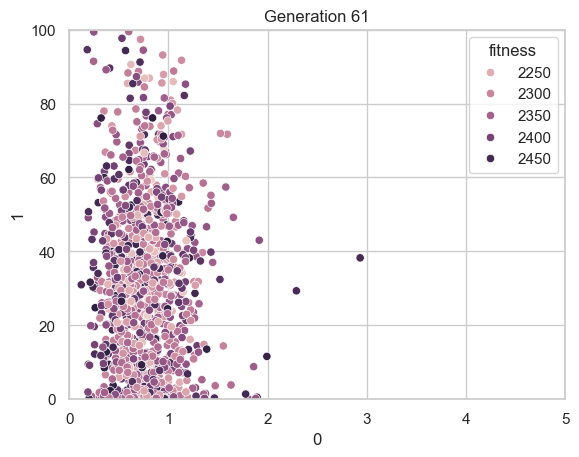

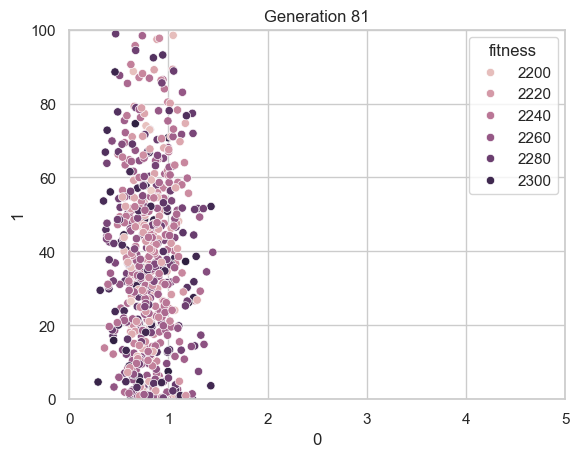

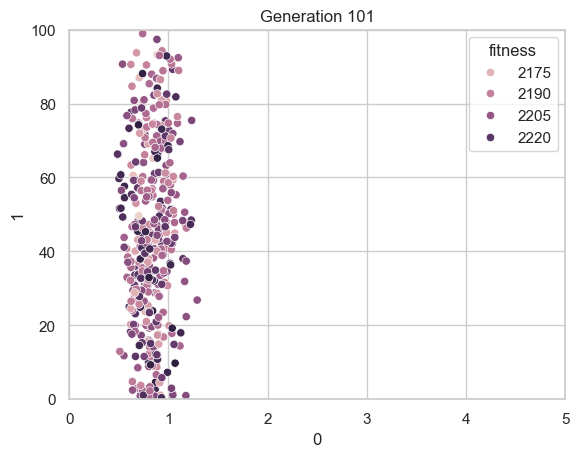

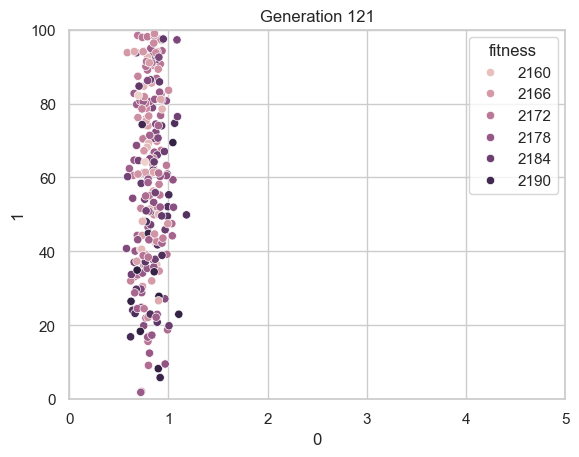

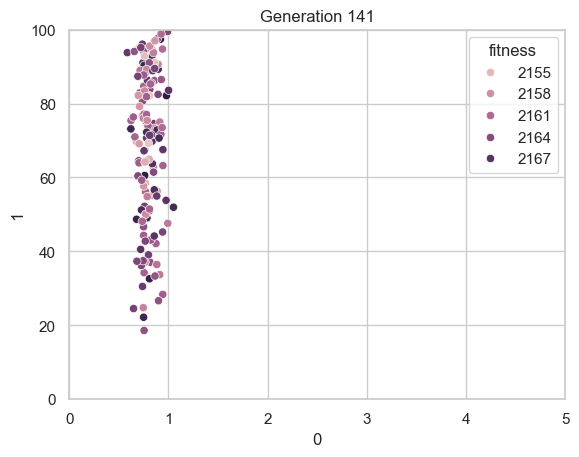

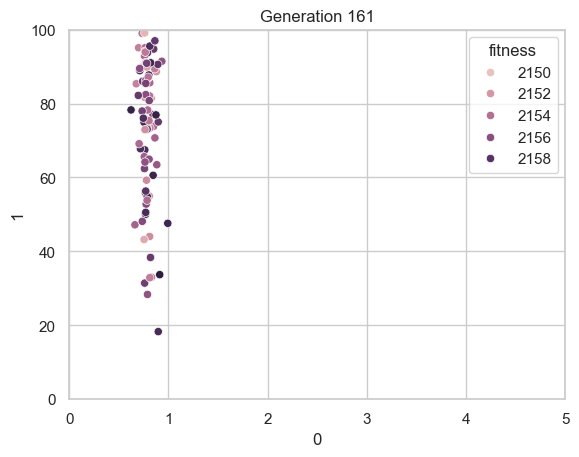

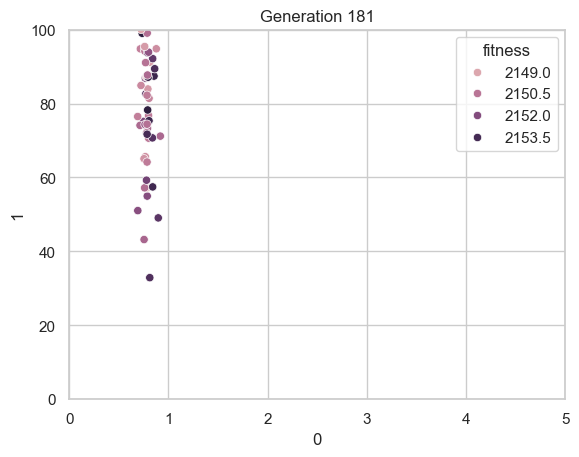

In [142]:
# scatterplot for generation 1 where x is alpha_0 and y is alpha_1
col1 = 0
col2 = 1
for gen_number in range(1, 201, 20):
    df = trained_df[
        (trained_df["generation"] == gen_number)
        & (trained_df["param_type"] == "beta")
        & (trained_df["param_index"].isin([col1, col2]))
    ]
    df = df.pivot(index="individual", columns="param_index", values="value")
    df = df.reset_index()
    df = df.merge(
        trained_df[trained_df["generation"] == gen_number][
            ["individual", "fitness"]
        ].drop_duplicates(),
        on="individual",
    )

    sns.scatterplot(data=df, x=col1, y=col2, hue="fitness")
    plt.xlim(0, 5)
    plt.ylim(0, 100)
    plt.title(f"Generation {gen_number}")
    plt.show()

In [116]:
import numpy as np


def compute_spectral_radius(df):
    # Initialize a list to store spectral radius results
    spectral_radii = []

    # Group by 'file'
    for file, group in df.groupby("individual"):
        # Reshape the 'rho' values into a 3x3 matrix for each file
        matrix = group["value"].values.reshape(3, 3)

        # Compute the eigenvalues of the matrix
        eigenvalues = np.linalg.eigvals(matrix)

        # The spectral radius is the maximum absolute eigenvalue
        spectral_radius = np.max(np.abs(eigenvalues))

        # Append the result to the list
        spectral_radii.append({"file": file, "spectral_radius": spectral_radius})

    # Convert the list of results into a DataFrame
    return pd.DataFrame(spectral_radii)


spectral_radius_df = compute_spectral_radius(
    trained_df[(trained_df["param_type"] == "rho") & (trained_df["generation"] == 201)]
)
spectral_radius_df

file  spectral_radius
0      0         0.860366
1      1         0.717714
2      2         0.882285
3      3         0.897902
4      4         0.951286
5      5         0.912807
6      6         0.622744
7      7         0.592319
8      8         0.734288
9      9         0.909477
10    10         0.906749
11    11         0.819965
12    12         0.858241
13    13         0.849562
14    14         0.823503
15    15         0.723784
16    16         0.856860
17    17         0.843160
18    18         0.780799
19    19         0.881415
20    20         0.779721
21    21         0.832688
22    22         0.891405
23    23         0.929867
24    24         0.820166
25    25         0.666089
26    26         0.826826
27    27         0.875653
28    28         0.862809
29    29         0.790223
30    30         0.880151

In [114]:
next_gen_individuals_fitnesses = np.loadtxt(
    Path(TRAINING_FOLDER)
    / "orderbook_changes_1705356920082_1705353321_logs"
    / f"fitnesses_gen201.tsv",
)
next_gen_individuals_fitnesses[9]

2243.1958862700167

## Punti da vedere

1. Errore fitness increase
2. Vedere perchè più scarso non è scartato

In [111]:
next_gen_individuals_fitnesses = np.loadtxt(
    Path(TRAINING_FOLDER)
    / "orderbook_changes_1705356920082_1705353321_logs"
    / f"fitnesses_gen190.tsv",
)

number_of_individuals_to_delete = 2

worst_individuals_indices = np.argpartition(
    next_gen_individuals_fitnesses, -number_of_individuals_to_delete
)[-number_of_individuals_to_delete:]
worst_individuals_indices

array([18, 16], dtype=int64)

In [107]:
next_gen_individuals_fitnesses

array([2235.75793332, 2240.15980713, 2241.64260796, 2245.80110685,
       2202.66795618, 2210.60770288, 2246.48852124, 2239.46294541,
       2246.88740109, 2238.32503978, 2245.17131715, 2245.3349872 ,
       2249.39856225, 2220.30523479, 2241.68300105, 2263.90623662,
       2640.81416433, 2300.12426669, 2318.5603305 , 2245.28756648,
       2234.07481003, 2232.13246238, 2252.91806907, 2239.49765463,
       2247.91782289, 2246.10500981, 2254.82495311, 2204.07690939,
       2256.53819814, 2236.23450788, 2249.46111638, 2185.3037241 ,
       2269.15871903, 2246.66498935, 2247.44998819, 2221.7903286 ,
       2248.11482309, 2235.94627729, 2234.93954401, 2260.4624572 ,
       2239.00647858])

In [109]:
np.argpartition(next_gen_individuals_fitnesses, -number_of_individuals_to_delete)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 40,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 16], dtype=int64)

array([   1,    4,    9,   16,   25,   36,   49,   64,   81, 1000])